## Forecasting No of Antidiabetic Drug Prescriptions

The objective of this project is to forecast the number of antidiabetic drug prescriptions in Australia from 1991 to 2008. Accurate forecasting of drug prescriptions is essential for optimizing production, ensuring sufficient supply to meet demand while avoiding overproduction. This project utilizes time series analysis techniques to build a predictive model using data recorded by the Australian Health Insurance Commission.

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose,STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [26]:
data=pd.read_csv('AusAntidiabeticDrug.csv')
data

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869
...,...,...
199,2008-02-01,21.654285
200,2008-03-01,18.264945
201,2008-04-01,23.107677
202,2008-05-01,22.912510


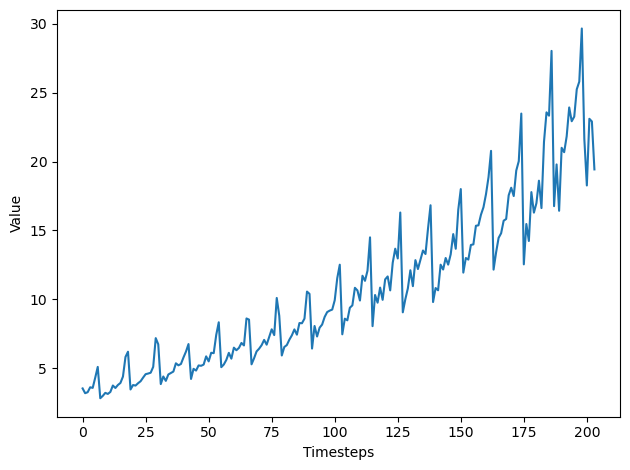

In [27]:
## PLotting the time Series
fig,ax = plt.subplots()

ax.plot(data['y'])

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()

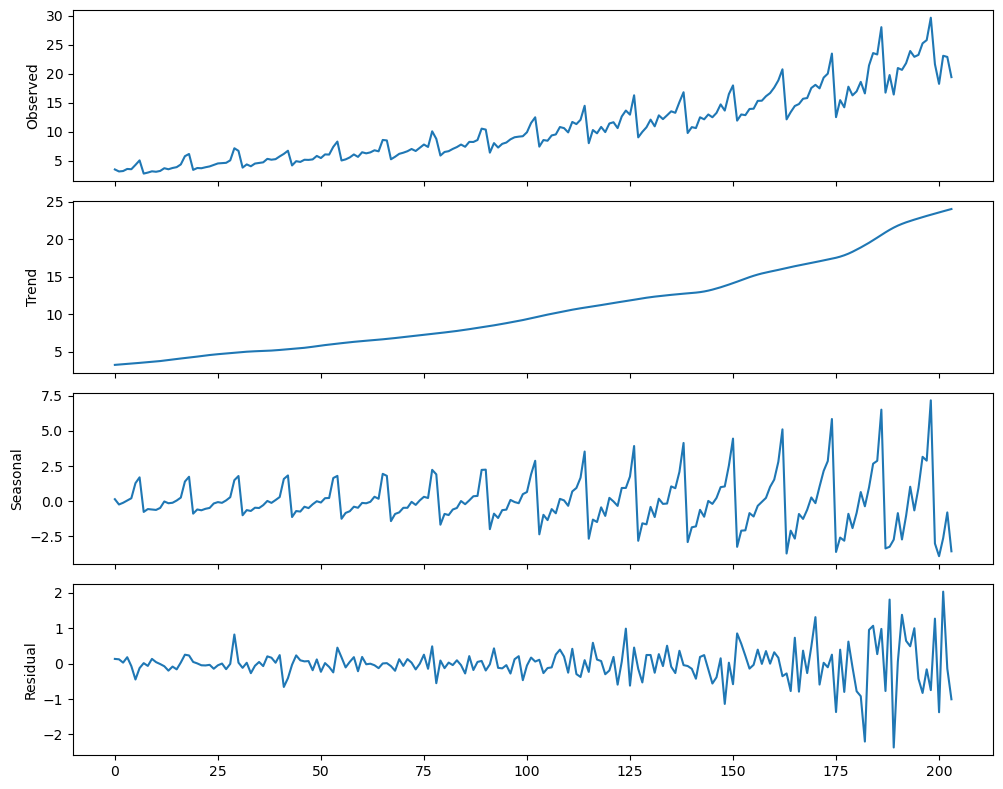

In [28]:
## Plotting the seasonal decomposition

decomposition=STL(data.y,period=12).fit()

fig,(ax1,ax2,ax3,ax4) = plt.subplots(nrows=4,ncols=1,sharex=True,figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residual')

plt.tight_layout()

### Steps to Perform:

1. **Stationary Check:** Check if the time series is stationary. Perform the ADF test and apply transformations if not stationary.

2. **Set Differencing Parameters:** Determine the necessary parameters for differencing \( d \) & \( D \).

3. **Define Model Parameters & Function:** List the set of different \( p, q, P, Q \) values to experiment and write the SARIMAX function.

4. **Fit the Model:** Train the model with every combination of parameter values.

5. **Model Selection:** Choose the model with the lowest AIC value.

6. **Residual Analysis:** Perform Q-Q plot for normality check and Ljung-Box test for correlation test.

7. **Forecasting:** Predict future values.

8. **Evaluate Forecast Accuracy:** Assess predictions using RMSE, MAE, or MAPE.

In [29]:
## 1) Stationary Check
print("Apply First ADF test on original time series")

adf_results=adfuller(data['y'])

print ("Test Statistic: ", adf_results[0])
print ("P Value: ", adf_results[1])

if adf_results[1]<0.05:
    print ("Time series has no unit root and it is stationary (Reject Null Hypothesis)")
else:
    print ("Time series is non-stationary and needs a tranformation")
print("\n")
print("Apply Second ADF test on differenced time series")
y_diff=np.diff(data['y'],n=1)
adf_results=adfuller(y_diff)

print ("Test Statistic: ", adf_results[0])
print ("P Value: ", adf_results[1])

if adf_results[1]<0.05:
    print ("Time series has no unit root and it is stationary (Reject Null Hypothesis)")
else:
    print ("Time series is non-stationary and needs a tranformation")


## Apply the differencing transformation
print("\n")
print("Apply Third ADF test on seasonal differenced time series")
seasonal_y_diff=np.diff(y_diff,n=12)
adf_results=adfuller(seasonal_y_diff)

print ("Test Statistic: ", adf_results[0])
print ("P Value: ", adf_results[1])

if adf_results[1]<0.05:
    print ("Time series has no unit root and it is stationary (Reject Null Hypothesis)")
else:
    print ("Time series is non-stationary and needs a tranformation")
    
    

Apply First ADF test on original time series
Test Statistic:  3.145185689306735
P Value:  1.0
Time series is non-stationary and needs a tranformation


Apply Second ADF test on differenced time series
Test Statistic:  -2.495172147449726
P Value:  0.11665341686469105
Time series is non-stationary and needs a tranformation


Apply Third ADF test on seasonal differenced time series
Test Statistic:  -19.848440098002758
P Value:  0.0
Time series has no unit root and it is stationary (Reject Null Hypothesis)


In [30]:
## 2) Set differencing paramaters

print("Based on above tests, d=1 and D=1")

Based on above tests, d=1 and D=1


In [47]:
## 3) Preparing the training function, dataset and paramters

def optimize_SARIMAX(data, order_list, d,D,s):
    results=[]
    
    for order in order_list:
        try:
        
            model=SARIMAX(data,
                          order=(order[0],d,order[1]),
                         seasonal_order=(order[2],D,order[3],s),
                         simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic=model.aic
        results.append([order,aic])
        
    results_df=pd.DataFrame(results)
    results_df.columns=['(p,q,P,Q)','AIC']
    results_df=results_df.sort_values(by='AIC',ascending=True)
    
    return results_df


## Preparing the train and test split data

train=data['y'][:168]
test=data['y'][168:]


ps=range(0,4)
qs=range(0,4)
Ps=range(0,4)
Qs=range(0,4)

order_list=list(product(ps,qs,Ps,Qs))


## SARIMA MODEL

In [48]:
## 4) Fit diffferent models
d=1
D=1
s=12

SARIMAX_results_df=optimize_SARIMAX(train,order_list,d,D,s)
SARIMAX_results_df

,"(p,q,P,Q)",AIC
214,"(3, 1, 1, 3)",270.951096
246,"(3, 3, 1, 3)",271.423117
230,"(3, 2, 1, 3)",272.222637
240,"(3, 3, 0, 1)",272.580414
247,"(3, 3, 2, 0)",272.949438
...,...,...
13,"(0, 0, 3, 1)",351.425175
5,"(0, 0, 1, 1)",351.466837
1,"(0, 0, 0, 1)",354.751719
4,"(0, 0, 1, 0)",357.173706


In [49]:
## 5) Selecting the best model based on lowest AIC value

model = SARIMAX(data['y'], order=(3,1,1),seasonal_order=(1,1,3,12)).fit()
residuals=model.resid

print(model.summary())

print("\n Residuals: ", residuals)

                                         SARIMAX Results                                          
Dep. Variable:                                          y   No. Observations:                  204
Model:             SARIMAX(3, 1, 1)x(1, 1, [1, 2, 3], 12)   Log Likelihood                -246.915
Date:                                    Sat, 22 Mar 2025   AIC                            511.831
Time:                                            10:11:08   BIC                            541.101
Sample:                                                 0   HQIC                           523.686
                                                    - 204                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0785      0.097     -0.812      0

1     0.973883
2     0.992754
3     0.991023
4     0.235967
5     0.349271
6     0.471281
7     0.587964
8     0.489477
9     0.535444
10    0.385419
Name: lb_pvalue, dtype: float64


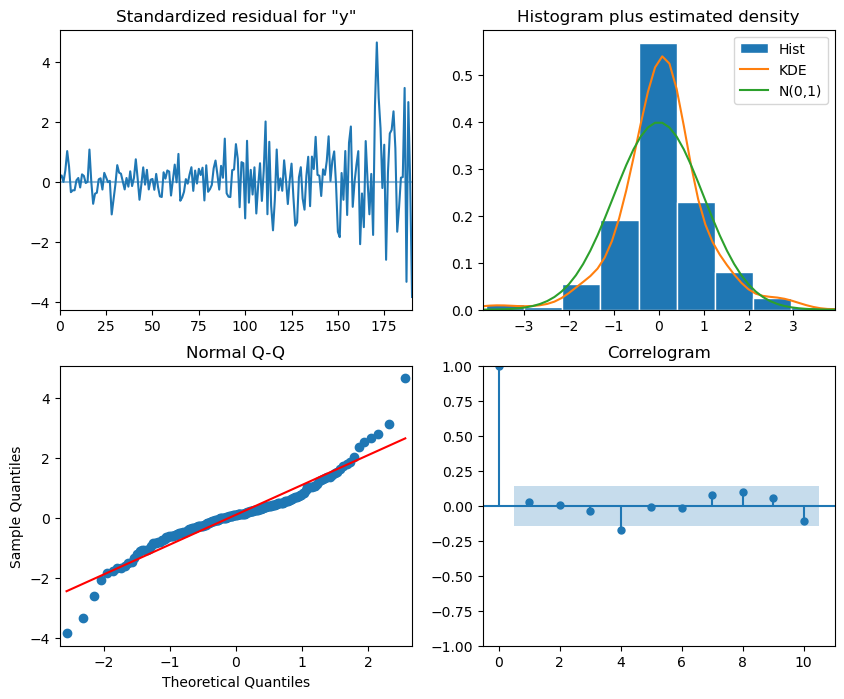

In [50]:
## 6) Residual analysis 

## Residuals should be normally distributed
## Check that residuals should be uncorrelated?

model.plot_diagnostics(figsize=(10, 8))


## Conducting Ljung - Box test

## H0: Data is independently distributed and no autocorrelation
## HA: Data is not independent and therefore autocorrelation exists

## We want pvalue to be greater that 0.05 so we can say there is no autocorrelation

ljung_res = sm.stats.acorr_ljungbox(residuals, lags=np.arange(1, 11, 1), return_df=True)

print(ljung_res['lb_pvalue'])

# if pvalue<0.05:
#     print ("Data is not independent and therefore autocorrelation exists")
# else:
#     print ("Data is independently distributed and no autocorrelation")

In [59]:
## 7) Forecasting the outcome values

def rolling_forecast(df,train_len,horizon,window,method):
    
    total_len=train_len+horizon
    end_idx=train_len
    
    if method=='SARIMA':
        pred_SARIMA=[]
        
        for i in range(train_len, total_len, window):
            
            model=SARIMAX(df['y'][:i],order=(3,1,1),seasonal_order=(1,1,3,12),simple_differencing=False)
            res=model.fit()
            
            predictions=res.get_prediction(0,i+window-1)
            oos_pred=predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)
        return pred_SARIMA
        
TRAIN_LEN=168
HORIZON=36
WINDOW=12

pred_df=data[168:]
pred_df['SARIMA']=rolling_forecast(data,TRAIN_LEN,HORIZON,WINDOW,'SARIMA')
pred_df.head()

,ds,y,SARIMA
168,2005-07-01,15.829550,16.745818
169,2005-08-01,17.554701,16.619350
170,2005-09-01,18.100864,17.255299
171,2005-10-01,17.496668,18.107505
172,2005-11-01,19.347265,18.722170


## Holt-Winters (Exponential Smoothing) model


In [62]:
def optimize_holt_winters(data, trend_list, seasonal_list, seasonal_periods):
    results = []
    
    for trend, seasonal in list(product(trend_list, seasonal_list)):
        if seasonal is None and trend is None:  
            continue 
        
        try:
            model = ExponentialSmoothing(data, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
            fitted_model = model.fit()
            predictions = fitted_model.fittedvalues
            mae = mean_absolute_error(data, predictions)
            
            results.append([(trend, seasonal), mae])
        
        except:
            continue 
    
    results_df = pd.DataFrame(results, columns=['(Trend, Seasonal)', 'MAE'])
    results_df = results_df.sort_values(by='MAE', ascending=True)
    
    return results_df


trend_options = ['add', 'mul', None]
seasonal_options = ['add', 'mul', None]
seasonal_periods = 12  

best_hw_params = optimize_holt_winters(train, trend_options, seasonal_options, seasonal_periods)
best_hw_params

,"(Trend, Seasonal)",MAE
4,"(mul, mul)",0.325786
1,"(add, mul)",0.338010
7,"(None, mul)",0.364826
3,"(mul, add)",0.384197
0,"(add, add)",0.390803
6,"(None, add)",0.426058
5,"(mul, None)",1.042640
2,"(add, None)",1.046317


#### Best model parameters are trend='mul' and seasonal='mul'

In [66]:
def rolling_forecast_holt_winters(df, train_len, horizon, window, trend, seasonal, seasonal_periods):
    total_len = train_len + horizon
    end_idx = train_len
    pred_hw = []
    
    for i in range(train_len, total_len, window):
        model = ExponentialSmoothing(df['y'][:i], trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
        res = model.fit()
        
        predictions = res.forecast(window)
        pred_hw.extend(predictions)
    
    return pred_hw

pred_df['HoltWinters'] = rolling_forecast_holt_winters(data, TRAIN_LEN, HORIZON, WINDOW, 'mul', 'mul', seasonal_periods)
pred_df.head()

,ds,y,SARIMA,HoltWinters
168,2005-07-01,15.829550,16.745818,16.839884
169,2005-08-01,17.554701,16.619350,16.671241
170,2005-09-01,18.100864,17.255299,16.995305
171,2005-10-01,17.496668,18.107505,18.338187
172,2005-11-01,19.347265,18.722170,18.568858


## Results

In [71]:
def mape(y_true,y_pred):
    
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

mape_SARIMA = mape(pred_df['y'],pred_df['SARIMA'])
mape_HOLTWINTERS = mape(pred_df['y'],pred_df['HoltWinters'])

mae_SARIMA = mean_absolute_error(pred_df['y'],pred_df['SARIMA'])
mae_HOLTWINTERS = mean_absolute_error(pred_df['y'],pred_df['HoltWinters'])

print(f"SARIMA → MAPE: {mape_SARIMA:.3f} | MAE: {mae_SARIMA:.3f}")
print(f"Holt-Winters → MAPE: {mape_HOLTWINTERS:.3f} | MAE: {mae_HOLTWINTERS:.3f}")


SARIMA → MAPE: 7.563 | MAE: 1.526
Holt-Winters → MAPE: 7.125 | MAE: 1.422


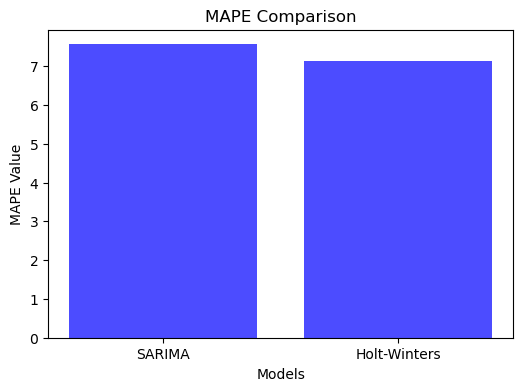

In [77]:
import matplotlib.pyplot as plt

# Define models and MAPE values
models = ["SARIMA", "Holt-Winters"]
mape_values = [mape_SARIMA, mape_HOLTWINTERS]

# Create the plot
plt.figure(figsize=(6, 4))
plt.bar(models, mape_values, color='blue', alpha=0.7)

# Labels and title
plt.xlabel("Models")
plt.ylabel("MAPE Value")
plt.title("MAPE Comparison")

# Show plot
plt.show()
